# Script for running PCA and plotting the results

## Before you begin

#### Copy the tools to 'bin/' and in each cell below, define paths to the tools.

## PCA

In [ ]:
%%bash

cd ../.. #star_protocols_saimaa
work=$(pwd)
apps=$work/bin

bcftools=$apps/bcftools
vcftools=$apps/vcftools
convertf=$apps/convertf
smartpca=$apps/smartpca

#Test with first 20 contigs

data=processed_data/2.masking-filtering/saimaa_20_phased_posmask
processed=processed_data/3.smartpca/saimaa_20_phased_posmask
results=results/3.smartpca/saimaa_20_phased_posmask

$bcftools view $data.vcf.gz | \
 perl -pe '($c)=/([0-9]+)F\|quiver\|pilon/;++$c;$c=~s/^0+//;s/([0-9]+)F\|quiver\|pilon/$c/' | \
 $vcftools --gzvcf - --plink --out $processed

cat > processed_data/3.smartpca/CONVERT << EOF
genotypename:    $processed.ped
snpname:         $processed.map 
indivname:       $processed.ped 
outputformat:    EIGENSTRAT
genotypeoutname: $processed.geno
snpoutname:      $processed.snp
indivoutname:    $processed.ind
familynames:     NO
EOF

$convertf -p processed_data/3.smartpca/CONVERT


cat > processed_data/3.smartpca/SMARTPCA << EOF
genotypename:    $processed.geno
snpname:         $processed.snp
indivname:       $processed.ind 
evecoutname:     $results.evec
evaloutname:     $results.eval
numoutevec:      10
numthreads:      4
EOF

$smartpca -p processed_data/3.smartpca/SMARTPCA > $results.out


**Note:** Eigensoft does not accept long contig names but requires the chromosomes to be numbers starting from one. The Perl command above deletes a fixed string from the contig name and, as the original numbers are from zero, adds one. There would be many other ways to achieve the same result.

**Note:** Eigensoft has an upper limit of a 100 chromosomes. If you are working with a draft assembly with > 100 contigs, you need to change parameter ``MAXCH`` in ``EIG/include/mcio.h`` before compiling the software to fit the number of contigs/chromosomes in your dataset.

**Note:** In the project's GitHub repository, .ped, .geno and .snp files have been compressed (gzip). If you do not start from the beginning but run smartpca using the files provided in the repository, the files need to be decompressed first (gzip -d).

## Visualisation

In [2]:
import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [ ]:
%%R

install.packages("tidyverse")

Saving 6.67 x 6.67 in image


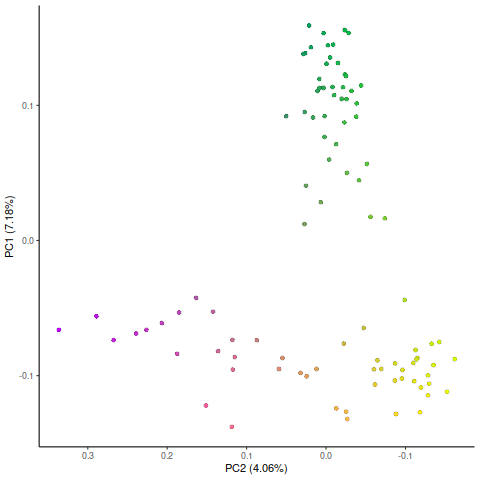

In [4]:
%%R

library(tidyverse)

setwd("../..")

pca <- read.table("results/3.smartpca/saimaa_20_phased_posmask.evec")
eig <- read.table("results/3.smartpca/saimaa_20_phased_posmask.eval")

colnames(pca)[2:11] <- paste0("PC",1:10)

e1 <- round(100*eig$V1[1]/sum(eig$V1),2)
e2 <- round(100*eig$V1[2]/sum(eig$V1),2)

m3 <- min(pca$PC1)
c3 <- max(pca$PC1)-m3
m4 <- min(pca$PC2)
c4 <- max(pca$PC2)-m4

pca$Color <- rgb(
  red=  1-(pca$PC1-m3)/c3, 
  green=1-(pca$PC2-m4)/c4, 
  blue=   (pca$PC2-m4)/c4)

colors <- cbind(pca$V1, pca$Color)

write.table(colors, "results/3.smartpca/colors.txt",row.names=F,quote=T, col.names=F, sep = "\t")

pca_plot <- ggplot(pca)+
  geom_point(aes(PC2,PC1,fill=I(Color)),size=2,shape=21,stroke=.1)+
  xlab(paste0("PC2 (",e2,"%)"))+ylab(paste0("PC1 (",e1,"%)"))+
  scale_x_reverse()+
  theme_classic()

ggsave("results/3.smartpca/pca_20ctgs.png", pca_plot)

pca_plot